# Quantifiying Classification Uncertainty in Deep Neural Networks

The purpose of this page is to provide an easy-to-run demo with low computational requirements for the ideas proposed in the paper _Evidential Deep Learning to Quantify Classification Uncertainty_. Using MNIST dataset, I demonstrate how to create neural networks that are able to quantify classification uncertainty. The paper can be accesed over http://arxiv.org/abs/1806.01768

#  Deep NNs with Softmax function

The following lines of codes demonstrate 

In [40]:
#import necessary libraries
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage as nd

%matplotlib inline
import pylab as pl
from IPython import display

from tensorflow.examples.tutorials.mnist import input_data

In [5]:
# Download MNIST dataset
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

K= 10 # number of classes

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


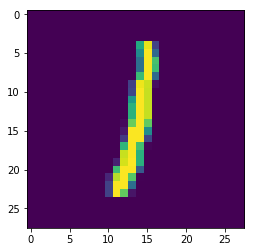

In [6]:
digit_one = mnist.train.images[4].copy()
plt.imshow(digit_one.reshape(28,28)) 
plt.show()

In [7]:
# define some utility functions
def var(name, shape, init=None):
    if init is None:
        init = tf.truncated_normal_initializer(stddev=(2/shape[0])**0.5)
    return tf.get_variable(name=name, shape=shape, dtype=tf.float32,
                          initializer=init)

def conv(Xin, f, strides=[1, 1, 1, 1], padding='SAME'):
    return tf.nn.conv2d(Xin, f, strides, padding)

def max_pool(Xin, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'):
    return tf.nn.max_pool(Xin, ksize, strides, padding)

def rotate_img(x, deg):
    import scipy.ndimage as nd
    return nd.rotate(x.reshape(28,28),deg,reshape=False).ravel()

In [92]:
# train LeNet network with softmax
def LeNet_softmax(lmb=0.01): 
    g = tf.Graph()
    with g.as_default():
        X = tf.placeholder(shape=[None,28*28], dtype=tf.float32)
        Y = tf.placeholder(shape=[None,10], dtype=tf.float32)
        keep_prob = tf.placeholder(dtype=tf.float32)
        
        # first hidden layer - conv
        W1 = var('W1', [5,5,1,20])
        b1 = var('b1', [20])
        out1 = max_pool(tf.nn.relu(conv(tf.reshape(X, [-1, 28,28, 1]), 
                                        W1, strides=[1, 1, 1, 1]) + b1))
        # second hidden layer - conv
        W2 = var('W2', [5,5,20,50])
        b2 = var('b2', [50])
        out2 = max_pool(tf.nn.relu(conv(out1, W2, strides=[1, 1, 1, 1]) + b2))
        # flatten the output
        Xflat = tf.contrib.layers.flatten(out2)
        # third hidden layer - fully connected
        W3 = var('W3', [Xflat.get_shape()[1].value, 500])
        b3 = var('b3', [500]) 
        out3 = tf.nn.relu(tf.matmul(Xflat, W3) + 3)
        out3 = tf.nn.dropout(out3, keep_prob=keep_prob)
        #output layer
        W4 = var('W4', [500,10])
        b4 = var('b4',[10])
        logits = tf.matmul(out3, W4) + b4
        
        prob = tf.nn.softmax(logits=logits) 
        
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
        l2_loss = (tf.nn.l2_loss(W3)+tf.nn.l2_loss(W4)) * lmb
        
        step = tf.train.AdamOptimizer().minimize(loss + l2_loss)
        
        # Calculate accuracy
        pred = tf.argmax(logits, 1)
        truth = tf.argmax(Y, 1)
        acc = tf.reduce_mean(tf.cast(tf.equal(pred, truth), tf.float32))
        
        return g, step, X, Y, keep_prob, prob, acc, loss

In [93]:
g1, step1, X1, Y1, keep_prob1, prob1, acc1, loss1 = LeNet_softmax()

In [169]:
sess1 = tf.Session(graph=g1)
with g1.as_default(): 
    sess1.run(tf.global_variables_initializer())

In [170]:
bsize = 1000 #batch size
n_batches = mnist.train.num_examples // bsize
for epoch in range(50):   
    for i in range(n_batches):
        data, label = mnist.train.next_batch(bsize)
        feed_dict={X1:data, Y1:label, keep_prob1:.5}
        sess1.run(step1,feed_dict)
        print('epoch %d - %d%%) '% (epoch+1, (100*(i+1))//n_batches), end='\r' if i<n_batches-1 else '')
        
    train_acc = sess1.run(acc1, feed_dict={X1:mnist.train.images,Y1:mnist.train.labels,keep_prob1:1.})
    test_acc = sess1.run(acc1, feed_dict={X1:mnist.test.images,Y1:mnist.test.labels,keep_prob1:1.})
    
    print('training accuracy: %2.4f \t testing accuracy: %2.4f' % (train_acc, test_acc))

epoch 1 - 100%) training accuracy: 0.9235 	 testing accuracy: 0.9255
epoch 2 - 100%) training accuracy: 0.9514 	 testing accuracy: 0.9510
epoch 3 - 100%) training accuracy: 0.9648 	 testing accuracy: 0.9644
epoch 4 - 100%) training accuracy: 0.9699 	 testing accuracy: 0.9685
epoch 5 - 100%) training accuracy: 0.9765 	 testing accuracy: 0.9732
epoch 6 - 100%) training accuracy: 0.9796 	 testing accuracy: 0.9744
epoch 7 - 100%) training accuracy: 0.9800 	 testing accuracy: 0.9766
epoch 8 - 100%) training accuracy: 0.9816 	 testing accuracy: 0.9767
epoch 9 - 100%) training accuracy: 0.9824 	 testing accuracy: 0.9787
epoch 10 - 100%) training accuracy: 0.9863 	 testing accuracy: 0.9812
epoch 11 - 100%) training accuracy: 0.9862 	 testing accuracy: 0.9822
epoch 12 - 100%) training accuracy: 0.9873 	 testing accuracy: 0.9831
epoch 13 - 100%) training accuracy: 0.9866 	 testing accuracy: 0.9816
epoch 14 - 100%) training accuracy: 0.9875 	 testing accuracy: 0.9826
epoch 15 - 100%) training acc

** Classification of Rotating Images **

In [167]:
def rotating_image_classification(img, sess, prob, X, keep_prob, uncertainty=None):
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    rimgs = np.zeros((28,28*Ndeg))
    for i,deg in enumerate(np.linspace(0,Mdeg, Ndeg)):
        nimg = rotate_img(img,deg).reshape(28,28)
        nimg = np.clip(a=nimg,a_min=0,a_max=1)
        rimgs[:,i*28:(i+1)*28] = nimg
        feed_dict={X:nimg.reshape(1,-1), keep_prob:1.0}
        if uncertainty is None:
            p_pred_t = sess.run(prob, feed_dict=feed_dict)
        else:
            p_pred_t,u = sess.run([prob,uncertainty], feed_dict=feed_dict)
            lu.append(u.mean())
        scores += p_pred_t >= 0.5
        ldeg.append(deg) 
        lp.append(p_pred_t[0])
    
    labels = np.arange(10)[scores[0].astype(bool)]
    lp = np.array(lp)[:,labels]
    c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*2
    labels = labels.tolist()
    for i in range(len(labels)):
        plt.plot(ldeg,lp[:,i],marker=marker[i],c=c[i])
    
    if uncertainty is not None:
        labels += ['uncertainty']
        plt.plot(ldeg,lu,marker='<',c='red')
        
    plt.legend(labels)
 
    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Classification Probability')
    plt.show()

    plt.figure(figsize=[6.2,100])
    plt.imshow(1-rimgs,cmap='gray')
    plt.axis('off')
    plt.show()

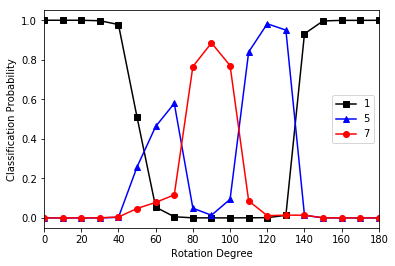

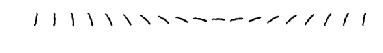

In [171]:
rotating_image_classification(digit_one, sess1, prob1, X1, keep_prob1)

# Evidential Deep Learning with Expected Mean Square Error

In [61]:
def KL(alpha):
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keep_dims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keep_dims=True)
    lnB = tf.lgamma(S_alpha) - tf.reduce_sum(tf.lgamma(alpha),axis=1,keep_dims=True)
    lnB_uni = tf.reduce_sum(tf.lgamma(beta),axis=1,keep_dims=True) - tf.lgamma(S_beta)
    
    dg0 = tf.digamma(S_alpha)
    dg1 = tf.digamma(alpha)
    
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keep_dims=True) + lnB + lnB_uni
    return kl

def mse_loss(p, alpha, global_step, annealing_step): 
    S = tf.reduce_sum(alpha, axis=1, keep_dims=True) 
    E = alpha - 1
    U = K / S
    m = alpha / S
    
    A = tf.reduce_sum((p-m)**2, axis=1, keep_dims=True) 
    B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keep_dims=True) 
    
    annealing_coef = tf.minimum(1.0,tf.cast(global_step/annealing_step,tf.float32))
    
    alp = E*(1-p) + 1 
    C =  annealing_coef * KL(alp)
    
    return (A + B) + C

In [155]:
# train LeNet network with expected mean square error loss
def LeNet_mse_dirichlet(lmb=0.005):
    g = tf.Graph()
    with g.as_default():
        X = tf.placeholder(shape=[None,28*28], dtype=tf.float32)
        Y = tf.placeholder(shape=[None,10], dtype=tf.float32)
        keep_prob = tf.placeholder(dtype=tf.float32)
        global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
        annealing_step = tf.placeholder(dtype=tf.int32) 
    
        # first hidden layer - conv
        W1 = var('W1', [5,5,1,20])
        b1 = var('b1', [20])
        out1 = max_pool(tf.nn.relu(conv(tf.reshape(X, [-1, 28,28, 1]), 
                                        W1, strides=[1, 1, 1, 1]) + b1))
        # second hidden layer - conv
        W2 = var('W2', [5,5,20,50])
        b2 = var('b2', [50])
        out2 = max_pool(tf.nn.relu(conv(out1, W2, strides=[1, 1, 1, 1]) + b2))
        # flatten the output
        Xflat = tf.contrib.layers.flatten(out2)
        # third hidden layer - fully connected
        W3 = var('W3', [Xflat.get_shape()[1].value, 500])
        b3 = var('b3', [500]) 
        out3 = tf.nn.relu(tf.matmul(Xflat, W3) + 3)
        out3 = tf.nn.dropout(out3, keep_prob=keep_prob)
        #output layer
        W4 = var('W4', [500,10])
        b4 = var('b4',[10])
        logits = tf.matmul(out3, W4) + b4
        
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1
        
        u = K / tf.reduce_sum(alpha, axis=1, keep_dims=True) #uncertainty
        
        prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        
        loss = tf.reduce_mean(mse_loss(Y, alpha, global_step, annealing_step))
        l2_loss = (tf.nn.l2_loss(W3)+tf.nn.l2_loss(W4)) * lmb
        
        step = tf.train.AdamOptimizer().minimize(loss + l2_loss, global_step=global_step)
        
        # Calculate accuracy
        pred = tf.argmax(logits, 1)
        truth = tf.argmax(Y, 1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        acc = tf.reduce_mean(match)
        
        total_evidence = tf.reduce_sum(evidence,1, keepdims=True) 
        mean_ev = tf.reduce_mean(total_evidence)
        mean_ev_succ = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*match) / tf.reduce_sum(match+1e-20)
        mean_ev_fail = tf.reduce_sum(tf.reduce_sum(evidence,1, keepdims=True)*(1-match)) / (tf.reduce_sum(tf.abs(1-match))+1e-20) 
        
        return g, step, X, Y, annealing_step, keep_prob, prob, acc, loss, u, evidence, mean_ev, mean_ev_succ, mean_ev_fail

In [156]:
g2, step2, X2, Y2, annealing_step, keep_prob2, prob2, acc2, loss2, u, evidence, \
    mean_ev, mean_ev_succ, mean_ev_fail= LeNet_mse_dirichlet()

In [172]:
sess2 = tf.Session(graph=g2)
with g2.as_default():
    sess2.run(tf.global_variables_initializer())

In [173]:
bsize = 1000 #batch size
n_batches = mnist.train.num_examples // bsize
L_train_acc1=[]
L_train_ev_s=[]
L_train_ev_f=[]
L_test_acc1=[]
L_test_ev_s=[]
L_test_ev_f=[]
for epoch in range(50):   
    for i in range(n_batches):
        data, label = mnist.train.next_batch(bsize)
        feed_dict={X2:data, Y2:label, keep_prob2:.5, annealing_step:10*n_batches}
        sess2.run(step2,feed_dict)
        print('epoch %d - %d%%) '% (epoch+1, (100*(i+1))//n_batches), end='\r' if i<n_batches-1 else '')
        
    train_acc, train_succ, train_fail = sess2.run([acc2,mean_ev_succ,mean_ev_fail], feed_dict={X2:mnist.train.images,Y2:mnist.train.labels,keep_prob2:1.})
    test_acc, test_succ, test_fail = sess2.run([acc2,mean_ev_succ,mean_ev_fail], feed_dict={X2:mnist.test.images,Y2:mnist.test.labels,keep_prob2:1.})
    
    L_train_acc1.append(train_acc)
    L_train_ev_s.append(train_succ)
    L_train_ev_f.append(train_fail)
    
    L_test_acc1.append(test_acc)
    L_test_ev_s.append(test_succ)
    L_test_ev_f.append(test_fail)
    
    print('training: %2.4f (%2.4f - %2.4f) \t testing: %2.4f (%2.4f - %2.4f)' % 
          (train_acc, train_succ, train_fail, test_acc, test_succ, test_fail))

epoch 1 - 100%) training: 0.9470 (29.9496 - 6.0470) 	 testing: 0.9525 (30.3331 - 6.2809)
epoch 2 - 100%) training: 0.9674 (33.9131 - 6.2303) 	 testing: 0.9695 (34.4653 - 7.0255)
epoch 3 - 100%) training: 0.9756 (33.1459 - 4.3576) 	 testing: 0.9762 (33.7443 - 4.1752)
epoch 4 - 100%) training: 0.9745 (33.9431 - 3.5602) 	 testing: 0.9749 (34.4402 - 3.7496)
epoch 5 - 100%) training: 0.9807 (36.8166 - 4.0170) 	 testing: 0.9789 (37.4320 - 4.1132)
epoch 6 - 100%) training: 0.9791 (36.6413 - 3.0833) 	 testing: 0.9803 (37.2622 - 3.1119)
epoch 7 - 100%) training: 0.9782 (39.2723 - 3.2930) 	 testing: 0.9778 (40.0590 - 3.1863)
epoch 8 - 100%) training: 0.9808 (37.4109 - 1.9068) 	 testing: 0.9800 (38.1145 - 2.2643)
epoch 9 - 100%) training: 0.9815 (39.3951 - 2.7377) 	 testing: 0.9805 (40.1664 - 2.9485)
epoch 10 - 100%) training: 0.9831 (40.2205 - 2.0345) 	 testing: 0.9830 (40.8734 - 2.4930)
epoch 11 - 100%) training: 0.9839 (40.3787 - 1.5182) 	 testing: 0.9840 (41.1746 - 1.7158)
epoch 12 - 100%) tr

In [195]:
def draw_EDL_results(train_acc1, train_ev_s, train_ev_f, test_acc1, test_ev_s, test_ev_f): 
    # calculate uncertainty for training and testing data for correctly and misclassified samples
    train_u_succ = K / (K+np.array(train_ev_s))
    train_u_fail = K / (K+np.array(train_ev_f))
    test_u_succ  = K / (K+np.array(test_ev_s))
    test_u_fail  = K / (K+np.array(test_ev_f))
    
    f, axs = pl.subplots(2, 2)
    f.set_size_inches([10,10])
    
    axs[0,0].plot(train_ev_s,c='r',marker='+')
    axs[0,0].plot(train_ev_f,c='k',marker='x')
    axs[0,0].set_title('Train Data')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_ylabel('Estimated total evidence for classification') 
    axs[0,0].legend(['Correct Clasifications','Misclasifications'])
    
    
    axs[0,1].plot(train_u_succ,c='r',marker='+')
    axs[0,1].plot(train_u_fail,c='k',marker='x')
    axs[0,1].plot(train_acc1,c='blue',marker='*')
    axs[0,1].set_title('Train Data')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_ylabel('Estimated uncertainty for classification')
    axs[0,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
    axs[1,0].plot(test_ev_s,c='r',marker='+')
    axs[1,0].plot(test_ev_f,c='k',marker='x')
    axs[1,0].set_title('Test Data')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_ylabel('Estimated total evidence for classification') 
    axs[1,0].legend(['Correct Clasifications','Misclasifications'])
    
    
    axs[1,1].plot(test_u_succ,c='r',marker='+')
    axs[1,1].plot(test_u_fail,c='k',marker='x')
    axs[1,1].plot(test_acc1,c='blue',marker='*')
    axs[1,1].set_title('Test Data')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Estimated uncertainty for classification')
    axs[1,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
    plt.show()

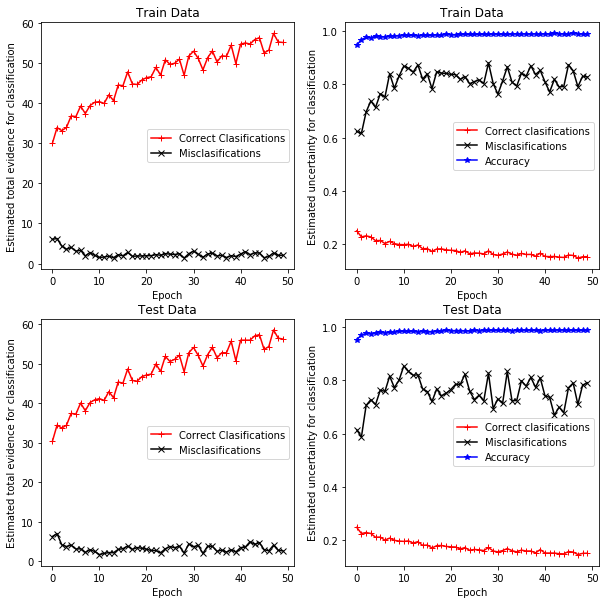

In [196]:
draw_EDL_results(L_train_acc1, L_train_ev_s, L_train_ev_f, L_test_acc1, L_test_ev_s, L_test_ev_f)

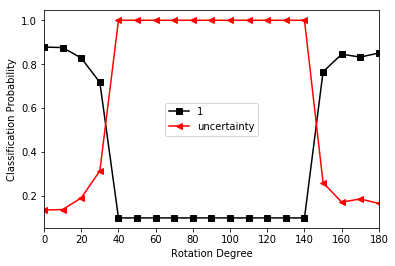

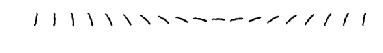

In [174]:
rotating_image_classification(digit_one, sess2, prob2, X2, keep_prob2, u)

# Evidential Deep Learning with Expected Cross Entropy